# **Foundations of Data Science Fall 2022 - Homework 3 (30 points)**

### Student Name: Yamini Lakshmi Narasimhan
### Student Net Id: yl9822

---

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection as well as bootstrapping for error estimation. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation (6 Points)
---



Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the data so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

Hint: as a guide, this function can easily be done in less than 15 lines.

In [1]:
# Place your code here
import pandas as pd
from sklearn.preprocessing import StandardScaler
def data_prep(filename):
    df = pd.read_csv(filename)
    df["Y"] = (df["Label"]=='s').astype(int)
    df.drop(["Label"],axis = 1, inplace = True)
    for i in df.columns:
        if -999.0 in df[i].values:
            df.loc[df[i] == -999.0, i+"_mv"] = 1
            df.loc[df[i] != -999.0, i+"_mv"] = df[i] 
        mean_value = df[df[i] != -999.0][i].mean()
        df[i] = df[i].replace(-999.0, mean_value)
    df_scaling = df.loc[:, df.columns != "Y"]
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df_scaling)
    scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df_scaling.columns)   
    scaled_features_df["Y"] = df["Y"]
    return scaled_features_df
            
        
    

### Part 2: Basic evaluations (6 Points)
---

In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1\. Clean the two data files included in this assignment (`data/boson_training_cut_2000.csv` and `data/boson_testing_cut.csv`) and use them as training and testing data sets.

(1 Point)

In [2]:
# Place your code here
#data_prep("./Downloads/Courses/FODS/Homework_3/data/boson_training_cut_2000.csv")

#data_prep("./Homework_3/data/boson_training_cut_2000.csv")
filename_train = "data/boson_training_cut_2000.csv"
filename_test = "data/boson_testing_cut.csv"
df_cleaned_train = data_prep(filename_train)
df_cleaned_test = data_prep(filename_test)

train_X = df_cleaned_train.loc[:, df_cleaned_train.columns != "Y"]
train_Y = df_cleaned_train["Y"]


test_X = df_cleaned_test.loc[:, df_cleaned_test.columns != "Y"]
test_Y = df_cleaned_test["Y"]


In [3]:
df_cleaned_train["Y"].value_counts()

0    1333
1     666
Name: Y, dtype: int64

In [4]:
df_cleaned_test

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_mass_MMC_mv,DER_deltaeta_jet_jet_mv,DER_mass_jet_jet_mv,DER_prodeta_jet_jet_mv,Y
0,-1.732016,-1.213348e-01,1.455304,0.099593,-0.447028,-4.699335e-16,0.000000,-5.739942e-17,0.007415,0.498029,0.176309,-0.362398,-0.399331,0.256351,0
1,-1.731947,-1.067373e+00,-0.715757,-0.854408,-0.103307,-4.699335e-16,0.000000,-5.739942e-17,-0.758743,1.730043,-0.552354,-0.362398,-0.399331,0.256351,0
2,-1.731878,-1.159847e-01,0.480365,0.064286,-0.297389,-2.874836e-01,0.664535,-7.332925e-02,0.465570,0.505136,0.180430,0.642076,1.489305,-0.689274,1
3,-1.731808,8.355185e-01,0.476970,0.482975,-0.882260,-4.699335e-16,0.000000,-5.739942e-17,1.416531,-0.804583,0.913302,-0.362398,-0.399331,0.256351,0
4,-1.731739,5.430718e-16,0.925326,-0.484386,-0.473912,-4.699335e-16,0.000000,-5.739942e-17,-0.195354,0.417565,-1.507808,-0.362398,-0.399331,0.256351,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1.731739,5.430718e-16,0.660266,-1.096784,-0.830865,-4.699335e-16,0.000000,-5.739942e-17,-1.256682,-0.650763,-1.507808,-0.362398,-0.399331,0.256351,0
49996,1.731808,5.430718e-16,0.266285,-0.320892,-0.559097,-4.699335e-16,0.000000,-5.739942e-17,0.274351,0.162616,-1.507808,-0.362398,-0.399331,0.256351,0
49997,1.731878,-3.119336e-01,0.333242,-0.130062,-0.288563,-4.699335e-16,0.000000,-5.739942e-17,0.024099,0.150647,0.029505,-0.362398,-0.399331,0.256351,1
49998,1.731947,-5.126784e-01,-0.841112,-0.302955,-0.698675,-4.699335e-16,0.000000,-5.739942e-17,1.275363,-0.255131,-0.125114,-0.362398,-0.399331,0.256351,0


2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference. 

(Hint: to get the prediction thresholds that are necessary for the AUC, use function predict_proba() for KNN and for the classifier you choose if it has it. If you work with SVM, use function decision_function().)

(4 Points)

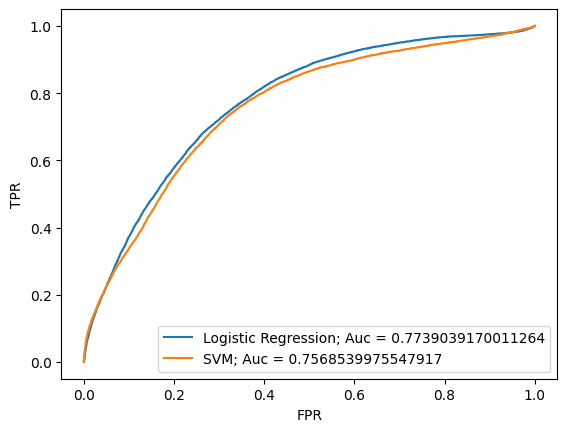

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
fig, ax = plt.subplots()

lgr = LogisticRegression(random_state=0, C=1e30).fit(train_X, train_Y)
fpr_lgr, tpr_lgr, thresholds = metrics.roc_curve(test_Y, lgr.predict_proba(test_X)[:, 1])
auc_lgr = metrics.roc_auc_score(test_Y, lgr.predict_proba(test_X)[:, 1])

ax.plot(fpr_lgr, tpr_lgr, label='Logistic Regression; Auc = '+ str(auc_lgr))

svmc = SVC(kernel = "linear").fit(train_X, train_Y)
fpr_svm, tpr_svm, thresholds = metrics.roc_curve(test_Y, svmc.decision_function(test_X))
auc_svm = metrics.roc_auc_score(test_Y, svmc.decision_function(test_X))
ax.plot(fpr_svm, tpr_svm, label ="SVM; Auc = " + str(auc_svm))
plt.xlabel("FPR")
plt.ylabel("TPR")
ax.legend()



/Users/yamini/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


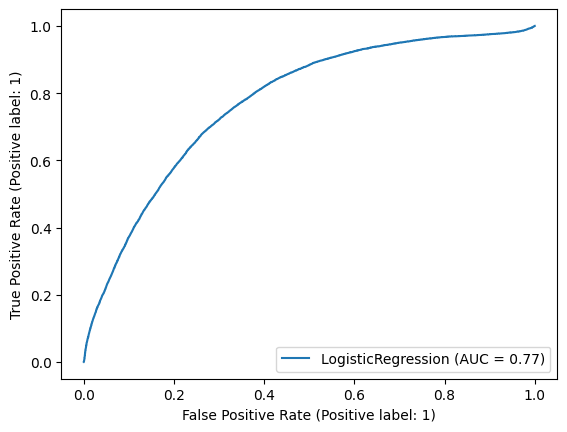

In [6]:
metrics.plot_roc_curve(lgr, test_X, test_Y) 

/Users/yamini/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


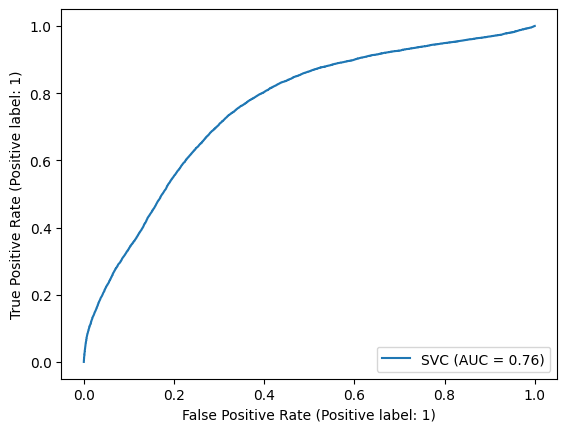

In [7]:
metrics.plot_roc_curve(svmc, test_X, test_Y) 

3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

(1 Point)

On the testing set Logistic Regression is better based on AUC as AUC is greater for logistic regression. Ah yes FPR less than 0.15 and greater than 0.95 can make svm perform slightly better than logistic regression as AUC ROC curve of SVM is overlapping with Logistic regression but I dont think there is a huge difference because they're kind of overlapping not really crossing the lines. So for that range TPR is kind of similar for values less than 0.15 in FPR and greater than 0.95 values in FPR

### Part 3: Model selection with cross-validation (8 Points)

We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 1000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Performs two loops
  - Outer Loop: `for each f in range(k)`:
    - Splits the data into `data_train` & `data_validate` according to cross-validation logic
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc-c1,auc-c2,..auc-ck]`
---

In [8]:
from sklearn.model_selection import *
from scipy.stats import sem
from sklearn.svm import SVC
import numpy as np

def xValSVM(dataset, label, k, C):
    auc = []
    dataset = dataset.sample(frac=1).reset_index(drop=True)
    auc_dict = {}
    for c in C:
        auc_dict[c] = []
    kf = KFold(n_splits = k, shuffle = True, random_state = 2)
    result = next(kf.split(dataset), None)
    
    X = dataset.loc[:, dataset.columns != label]
    y = dataset[label]

    #Implementing cross validation

    kf = KFold(n_splits=k, random_state=None)
    acc_score = []
    for train_index , test_index in kf.split(X):
        temp = []
        train_X , val_X = X.iloc[train_index,:],X.iloc[test_index,:]
        train_Y , val_Y = y[train_index] , y[test_index]
        for c in C:
            svmc = SVC(kernel = "linear", C = c).fit(train_X, train_Y)
            auc_c = metrics.roc_auc_score(val_Y, svmc.decision_function(val_X))
            auc_dict[c].append(auc_c)
    return auc_dict
            

2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1).
2.	Call aucs = xValSVM(train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) 
4.	Compute the value for max(meanAUC-StdErr(AUC)) across all values of c.
5.	Generate a plot with the following:
a.	Log10(c) on the x-axis
b.	1 series with mean(AUC) for each c
c.	1 series with mean(AUC)-stderr(AUC) for each c (use ‘k+’ as color pattern)
d.	1 series with mean(AUC)+stderr(AUC) for each c (use ‘k--‘ as color pattern)
e.	a reference line for max(AUC-StdErr(AUC)) (use ‘r’ as color pattern)


In [9]:
# Place your code here
C = []
C.append(10)
for i in range(0, 8):
    C.append(10**-i)

auc_dict = xValSVM(df_cleaned_train, "Y", 10,  C) 

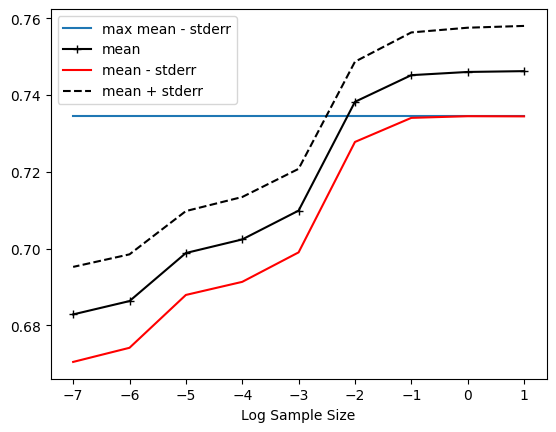

In [10]:
import math
import matplotlib.pyplot as plt
from scipy.stats import sem

fig, ax = plt.subplots()

auc_df = pd.DataFrame.from_dict(auc_dict)

l = []
for i in auc_df.columns:
    l.append(sem(auc_df[i]))
    
    
auc_describe_df = auc_df.describe()


auc_describe_df.loc['stderr'] = l
auc_describe_df.loc['mean-stderr'] = auc_describe_df.loc['mean'] - auc_describe_df.loc['stderr']
auc_describe_df.loc['mean+stderr'] = auc_describe_df.loc['mean'] + auc_describe_df.loc['stderr']

log_C = [math.log(c,10) for c in C]

cols = ["mean", 'mean-stderr', 'mean+stderr']
max_mean_std = max(auc_describe_df.loc["mean-stderr"].tolist())
max_mean_std_list = []

for i in range(len(C)):
    max_mean_std_list.append(max_mean_std)

ax.plot(log_C, max_mean_std_list, label="max mean - stderr")
    
y_axis = auc_describe_df.loc["mean"].tolist()
ax.plot(log_C, y_axis, 'k+-', label = "mean" )


y_axis = auc_describe_df.loc['mean-stderr'].tolist()
ax.plot(log_C, y_axis, 'r', label = "mean - stderr" )


y_axis = auc_describe_df.loc['mean+stderr'].tolist()
ax.plot(log_C, y_axis, 'k--', label = "mean + stderr" )

plt.xlabel("Log Sample Size")
    
ax.legend()

In [11]:
auc_describe_df

,1.000000e+01,1.000000e+00,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-04,1.000000e-05,1.000000e-06,1.000000e-07
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.746219,0.746006,0.745174,0.738228,0.709893,0.702387,0.698848,0.686332,0.682858
std,0.037242,0.036435,0.035185,0.033052,0.034399,0.034945,0.034539,0.038479,0.039133
min,0.684257,0.684478,0.683704,0.676070,0.649851,0.642881,0.639451,0.624196,0.618082
25%,0.728483,0.728534,0.728051,0.718889,0.701343,0.694754,0.691923,0.678311,0.678971
50%,0.749503,0.748364,0.747775,0.744586,0.709690,0.703725,0.701453,0.689063,0.681673
75%,0.765782,0.765117,0.761280,0.753371,0.727005,0.717333,0.714134,0.702515,0.698379
max,0.809972,0.808594,0.807100,0.798828,0.775046,0.769761,0.763902,0.763097,0.759766
stderr,0.011777,0.011522,0.011126,0.010452,0.010878,0.011050,0.010922,0.012168,0.012375
mean-stderr,0.734442,0.734484,0.734047,0.727776,0.699015,0.691336,0.687926,0.674164,0.670483


In [12]:
svmc = SVC(kernel = "linear", C = 10).fit(train_X, train_Y)
fpr_svm, tpr_svm, thresholds = metrics.roc_curve(test_Y, svmc.decision_function(test_X))
auc_svm = metrics.roc_auc_score(test_Y, svmc.decision_function(test_X))
print("AUC SVM",auc_svm)

AUC SVM 0.7572919520125211


Did the model parameters selected beat the out-of-the-box model for SVM? (1 point)

SVM AUC was 0.7568 whereas after running it for different values at mean AUC peaking at 10 the SVM AUC is 0.75729
Not a huge difference but to some extent yes it did beat out of the box model for SVM

### Part 4: Learning Curve with Bootstrapping (10 Points)
---




In this HW we are trying to find the best linear model to predict if a record represents the Higgs Boson. One of the drivers of the performance of a model is the sample size of the training set.  As a data scientist, sometimes you have to decide if you have enough data or if you should invest in more.  We can use learning curve analysis to determine if we have reached a performance plateau. This will inform us on whether or not we should invest in more data (in this case it would be by running more experiments).

Given a training set of size $N$, we test the performance of a model trained on a subsample of size $N_i$, where $N_i<=N$.  We can plot how performance grows as we move $N_i$ from $0$ to $N$.  

Because of the inherent randomness of subsamples of size $N_i$, we should expect that any single sample of size $N_i$ might not be representative of an algorithm’s performance at a given training set size. To quantify this variance and get a better generalization, we will also use bootstrap analysis. In bootstrap analysis, we pull multiple samples of size $N_i$, build a model, evaluate on a test set, and then take an average and standard error of the results.

1\. Create a bootstrap function that can do the following:

def modBootstrapper(train, test, nruns, sampsize, lr, c):

-	Takes as input:
    -	A master training file (train)
    -	A master testing file (test)
    -	Number of bootstrap iterations (nruns) 
    -	Size of a bootstrap sample (sampsize)
    -	An indicator variable to specific LR or SVM (lr=1)
    -	A c option (only applicable to SVM)

-	Runs a loop with (nruns) iterations, and within each loop:
    -	Sample (sampsize) instances from train, with replacement
    -	Fit either an SVM or LR (depending on options specified). For SVM, use the value of C identified using the 1 standard error method from part 3.    
    -	Computes AUC on test data using predictions from model in above step
    -	Stores the AUC in a list

-	Returns the mean(AUC) and Standard Error(mean(AUC)) across all bootstrap samples


In [13]:
# Place your code here
def modBootstrapper(train, test, nruns, sampsize, lr, c=0):
    '''
    Samples with replacement, runs multiple train/eval attempts
    returns mean and stdev of AUC
    '''   
    
    auc_samplesize = {}
    for j in sampsize:
        auc_samplesize[j] = []
        
    for j in sampsize:
        for i in range(nruns):
            df_sample = train.sample(n=j, replace=True)
            train_X = df_sample.loc[:, df_sample.columns != "Y"]
            train_Y = df_sample["Y"]

            test_X = test.loc[:, test.columns != "Y"]
            test_Y = test["Y"]
            
            if lr:
                svmc = SVC(kernel = "linear", C = 10).fit(train_X, train_Y)
                auc_c_svm = metrics.roc_auc_score(test_Y, svmc.decision_function(test_X))
                auc_samplesize[j].append(auc_c_svm)
                
            else:
                lgr = LogisticRegression(random_state=0, C=1e30).fit(train_X, train_Y)
                auc_c_lgr = metrics.roc_auc_score(test_Y, lgr.predict_proba(test_X)[:, 1])
                auc_samplesize[j].append(auc_c_lgr)
                
           

    return auc_samplesize
            

2\. For both LR and SVM, run 20 bootstrap samples for each samplesize in the following list: samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]. (Note, this might take 10-15 mins … feel free to go grab a drink or watch Youtube while this runs).

Generate a plot with the following:
-	Log2(samplesize) on the x-axis
-	2 sets of results lines, one for LR and one for SVM, the set should include
    -	1 series with mean(AUC) for each sampsize (use the color options ‘g’ for svm, ‘r’ for lr)
    -	1 series with mean(AUC)-stderr(AUC) for each c (use ‘+’ as color pattern, ‘g’,’r’ for SVM, LR respectively)
    -	1 series with mean(AUC)+stderr(AUC) for each c (use ‘--‘ as color pattern ‘g’,’r’ for SVM, LR respectively)

(6 Points. Same as above, this section does not work without above section, so the points are coupled)

In [19]:
# Place your code here
samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]
auc_samplesize_svm = modBootstrapper(df_cleaned_train, df_cleaned_test, 20, samplesizes, 1)
auc_samplesize_lgr = modBootstrapper(df_cleaned_train, df_cleaned_test, 20, samplesizes, 0)

/Users/yamini/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yamini/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

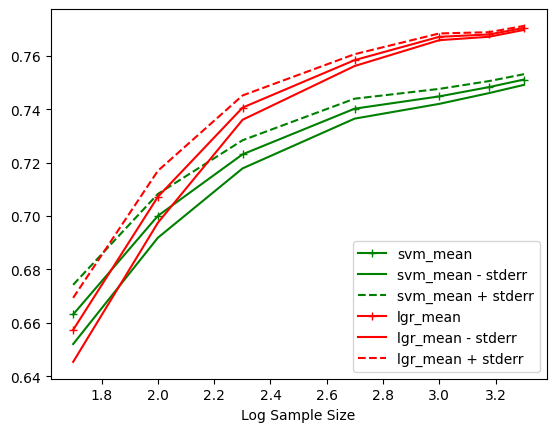

In [20]:
#def plotting(samplesizes, auc_samplesize, color):

log_samplesizes = [math.log(c,10) for c in samplesizes]
auc_df_svm = pd.DataFrame.from_dict(auc_samplesize_svm)
auc_describe_df_svm = auc_df_svm.describe()

l = []
for i in auc_df_svm.columns:
    l.append(sem(auc_df_svm[i]))

auc_describe_df_svm.loc['stderr'] = l

auc_describe_df_svm.loc['mean-stderr'] = auc_describe_df_svm.loc['mean'] - auc_describe_df_svm.loc['stderr']
auc_describe_df_svm.loc['mean+stderr'] = auc_describe_df_svm.loc['mean'] + auc_describe_df_svm.loc['stderr']

fig, ax = plt.subplots()

y_axis = auc_describe_df_svm.loc["mean"].tolist()
ax.plot(log_samplesizes, y_axis, "g+-", label = "svm_mean" )

y_axis = auc_describe_df_svm.loc['mean-stderr'].tolist()
ax.plot(log_samplesizes, y_axis, 'g', label = "svm_mean - stderr" )

y_axis = auc_describe_df_svm.loc['mean+stderr'].tolist()
ax.plot(log_samplesizes, y_axis, "g--", label = "svm_mean + stderr" )


auc_df_lgr = pd.DataFrame.from_dict(auc_samplesize_lgr)
auc_describe_df_lgr = auc_df_lgr.describe()

l = []
for i in auc_df_lgr.columns:
    l.append(sem(auc_df_lgr[i]))

auc_describe_df_lgr.loc['stderr'] = l

auc_describe_df_lgr.loc['mean-stderr'] = auc_describe_df_lgr.loc['mean'] - auc_describe_df_lgr.loc['stderr']
auc_describe_df_lgr.loc['mean+stderr'] = auc_describe_df_lgr.loc['mean'] + auc_describe_df_lgr.loc['stderr']

y_axis = auc_describe_df_lgr.loc["mean"].tolist()
ax.plot(log_samplesizes, y_axis, "r+-", label = "lgr_mean" )

y_axis = auc_describe_df_lgr.loc['mean-stderr'].tolist()
ax.plot(log_samplesizes, y_axis, 'r', label = "lgr_mean - stderr" )

y_axis = auc_describe_df_lgr.loc['mean+stderr'].tolist()
ax.plot(log_samplesizes, y_axis, "r--", label = "lgr_mean + stderr" )

plt.xlabel("Log Sample Size")
ax.legend()

3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?

(2 Points)

For smaller sample sizes, Svm seems better that is for sizes around 50-100 then there is steep increase by logistic regression.
Since mean AUC is increasing as sample sizes increases it is worth the investment but once it plateaus its not worth it as there is not going to be a huge change in Auc even after doubling the data
So for smaller sizes its worth but larger sizes its not worth the investment

4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased? (Hint: refer to the book - The Elements of Statistical Learning figure 7.8)?

(2 Points)

So in this case it shows that logistic regression is plateauing for higher values of sample size that is around 1000 - 2000 which means its biased upward.
Performance of our classifier over training sets of size 1000 is virtually the same as the performance for training set size 2000. Thus cross-validation would not suffer from much bias. 

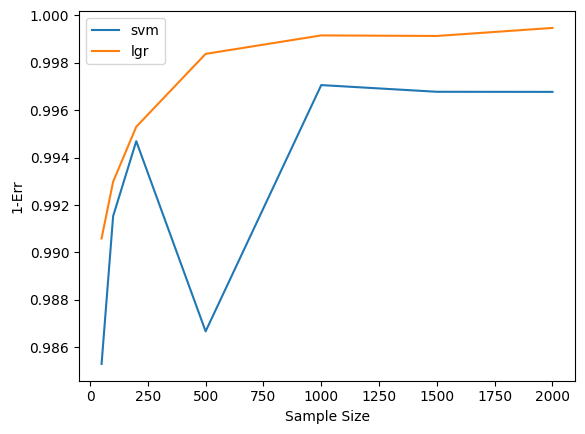

In [16]:
svm = []
for i in auc_df_svm.columns:
    svm.append(1-sem(auc_df_svm[i]))
    
    
lgr = []
for i in auc_df_lgr.columns:
    lgr.append(1-sem(auc_df_lgr[i]))

fig, ax = plt.subplots()
ax.plot(samplesizes,svm, label="svm") 
ax.plot(samplesizes,lgr, label ="lgr") 
plt.xlabel("Sample Size")
plt.ylabel("1-Err")
ax.legend()